<a href="https://colab.research.google.com/github/rbbh/Forecasting-Time-Series-with-Hybrid-Algorithms/blob/master/SVR_%2B_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
from google.colab import files
uploaded = files.upload()

Saving airlines2.txt to airlines2.txt


In [0]:
import io
import pandas as pd
data = pd.read_csv(io.BytesIO(uploaded['airlines2.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['DadosONS.txt']))

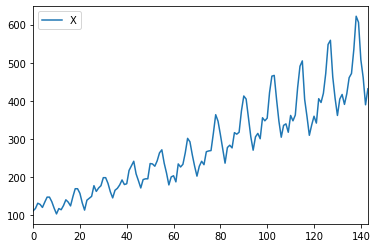

In [4]:
data.plot()


In [5]:
# Lag used for the prediction
# We will use 12 for the lag because 
# the series repeats itself annually

dimensions = 12
data_c = pd.concat([data.shift(i) for i in range(0 + dimensions + 1)], axis = 1)
print(data_c)

       X      X      X      X      X  ...      X      X      X      X      X
0    112    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
1    118  112.0    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
2    132  118.0  112.0    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
3    129  132.0  118.0  112.0    NaN  ...    NaN    NaN    NaN    NaN    NaN
4    121  129.0  132.0  118.0  112.0  ...    NaN    NaN    NaN    NaN    NaN
..   ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
139  606  622.0  535.0  472.0  461.0  ...  405.0  362.0  407.0  463.0  559.0
140  508  606.0  622.0  535.0  472.0  ...  417.0  405.0  362.0  407.0  463.0
141  461  508.0  606.0  622.0  535.0  ...  391.0  417.0  405.0  362.0  407.0
142  390  461.0  508.0  606.0  622.0  ...  419.0  391.0  417.0  405.0  362.0
143  432  390.0  461.0  508.0  606.0  ...  461.0  419.0  391.0  417.0  405.0

[144 rows x 13 columns]


In [0]:
# Normalizing the data

data_c = data_c/data_c.max() 

In [7]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_c.iloc[12:,1:]
y = data_c.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))



26
27
79


In [0]:
# Function that displays tridimensional plot
def plot(some_list):
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

In [0]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-1
    max_e = 1e-1
    min_e = 1e-4
    max_g = 1e0
    min_g = 1e-3
    
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles's parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    # TODO: Create function for thresholds
    threshold = 10e100
    threshold2 = 10e100
    threshold3 = 10e100
    
    best_iter = np.zeros(iterations)

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    g_bests = []
    g1 = []
    g2 = []
    g3 = []
    for i in range(iterations):
        #av_pbest = []
        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point 
          # is less than prior particle's personal best point,
          # replace personal best
          if(mse < threshold):
              threshold = mse
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = threshold
              bestRGS = rgs

              # The value below represents the current search coordinates for
              # the current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]
              # Assigning Particle's current best position to the Group's best
              g_best = p_best[aux].copy()
              

          #p_bests.append(p_best[j])  

          #from sklearn.metrics.pairwise import euclidean_distances

          #d_pbests = euclidean_distances(p_best[j], [[[0 , 0 , 0]]])
          #np.array(d_pbests[j])
          #np.array(j)
          #d_pbests_index.append(np.concatenate((d_pbests[j],j), axis = 1))

        for j in range(n_particles):
            rand1 = np.random.random()
            rand2 = np.random.random()

            # The variable below influences directly the particle's velocity.
            # It can either make it smaller or bigger. 
            w = inertia

            # The equation below represents Particle's velocity, which is
            # the rate of change in its position
            v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

            # Change in the Particle's position 
            c[j] = c[j] + v[j]

            # Below is a series of conditions that stop the particles from
            # leaving the search space
            if(c[j][2] < min_g):
              c[j][2] = min_g
            if(c[j][2] > max_g):
              c[j][2] = max_g
            if(c[j][1] < min_e):
              c[j][1] = min_e
            if(c[j][1] > max_e):
              c[j][1] = max_e
            if(c[j][0] < min_c):
              c[j][0] = min_c
            if(c[j][0] > max_c):
              c[j][0] = max_c
            
       
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val
        g_bests.append(g_best)  

        print('Best value iteration # %d = %f\n'%(i, g_best_val))


    # The variable below represents the average of all group's best
    # locations  
    av_gbest = sum(g_bests)/iterations
            
    i = 0
    
    rgs_av = svm.SVR(C = av_gbest[i], epsilon = av_gbest[i+1], gamma = av_gbest[i+2])
    
    rgs_av.fit(X_train, y_train)
    y_predict = rgs_av.predict(X_val)
    mse2 = mean_squared_error(y_val, y_predict)
    
    for m in range(len(g_bests)):
      g1.append(g_bests[m][0])
      g2.append(g_bests[m][1])
      g3.append(g_bests[m][2]) 

    import statistics as st

    m1 = st.median(g1)
    m2 = st.median(g2)
    m3 = st.median(g3)

    median = np.array([m1,m2,m3])

    i = 0

    rgs_md = svm.SVR(C = median[i], epsilon = median[i+1], gamma = median[i+2])
    
    rgs_md.fit(X_train, y_train)
    y_predict = rgs_md.predict(X_val)
    mse3 = mean_squared_error(y_val, y_predict)

    # Coordinates found after all the iterations
    print('Group Best value found: ')
    print(g_best)
    print('\n')
    print('Final Average value found: ')
    print(av_gbest)
    print('\n')
    print('Final Median value found: ')
    print(median)
    print('\n')


    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test= bestRGS.predict(X_test)

    # Displaying actual values and predicted values in a graph
    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_test, predict_test)
    print('Least mean squared error: %f' %mse)

 
    predict_test= rgs_av.predict(X_test)

    # Displaying actual values and predicted values in a graph for
    # the average values
    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted with Average Values')
    plt.legend()
    plt.show()

    mse2 = mean_squared_error(y_test, predict_test)
    print('Least mean squared error for the average values: %f' %mse2)

    
    predict_test= rgs_md.predict(X_test)

    # Displaying actual values and predicted values in a graph for
    # the median values
    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted with Median Values')
    plt.legend()
    plt.show()
            
    mse3 = mean_squared_error(y_test, predict_test)
    print('Least mean squared error for the median value: %f' %mse3)

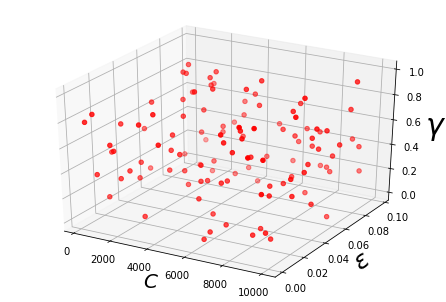

Best value iteration # 0 = 0.000882

Best value iteration # 1 = 0.000849

Best value iteration # 2 = 0.000832

Best value iteration # 3 = 0.000827

Best value iteration # 4 = 0.000827

Best value iteration # 5 = 0.000827

Best value iteration # 6 = 0.000827

Best value iteration # 7 = 0.000827

Best value iteration # 8 = 0.000827

Best value iteration # 9 = 0.000827

Best value iteration # 10 = 0.000827

Best value iteration # 11 = 0.000827

Best value iteration # 12 = 0.000827

Best value iteration # 13 = 0.000827

Best value iteration # 14 = 0.000827

Best value iteration # 15 = 0.000827

Best value iteration # 16 = 0.000827

Best value iteration # 17 = 0.000827

Best value iteration # 18 = 0.000827

Best value iteration # 19 = 0.000822

Best value iteration # 20 = 0.000822

Best value iteration # 21 = 0.000822

Best value iteration # 22 = 0.000822

Best value iteration # 23 = 0.000822

Best value iteration # 24 = 0.000822

Best value iteration # 25 = 0.000822

Best value iteration #

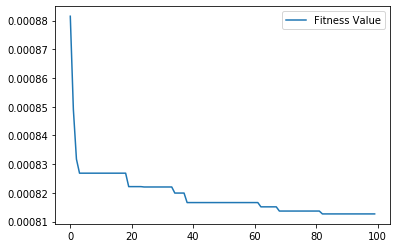

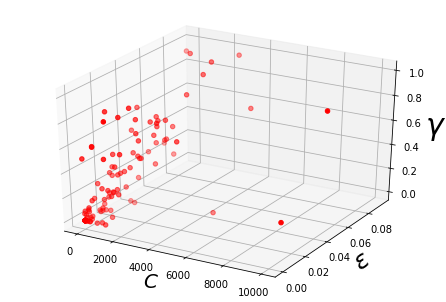

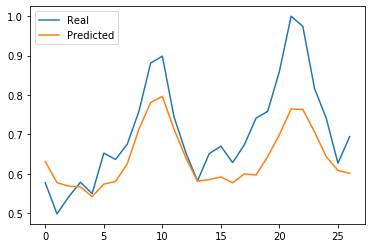

Least mean squared error: 0.009412


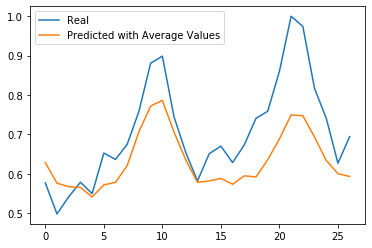

Least mean squared error for the average values: 0.010762


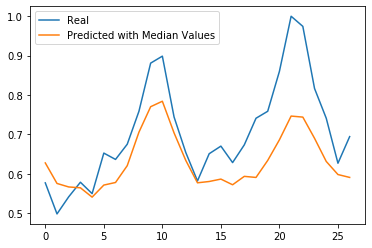

Least mean squared error for the median value: 0.011079


In [39]:
pso(120, 100, 3, 1)

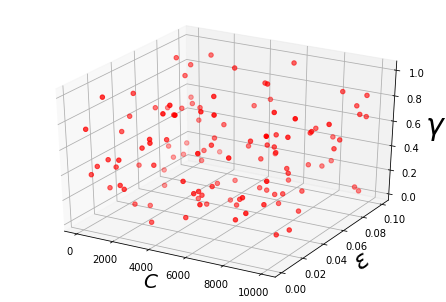

Best value iteration # 0 = 0.001069

Best value iteration # 1 = 0.000967

Best value iteration # 2 = 0.000842

Best value iteration # 3 = 0.000842

Best value iteration # 4 = 0.000822

Best value iteration # 5 = 0.000822

Best value iteration # 6 = 0.000822

Best value iteration # 7 = 0.000816

Best value iteration # 8 = 0.000816

Best value iteration # 9 = 0.000816

Best value iteration # 10 = 0.000816

Best value iteration # 11 = 0.000816

Best value iteration # 12 = 0.000816

Best value iteration # 13 = 0.000816

Best value iteration # 14 = 0.000816

Best value iteration # 15 = 0.000816

Best value iteration # 16 = 0.000811

Best value iteration # 17 = 0.000811

Best value iteration # 18 = 0.000811

Best value iteration # 19 = 0.000811

Best value iteration # 20 = 0.000811

Best value iteration # 21 = 0.000811

Best value iteration # 22 = 0.000811

Best value iteration # 23 = 0.000811

Best value iteration # 24 = 0.000811

Best value iteration # 25 = 0.000811

Best value iteration #

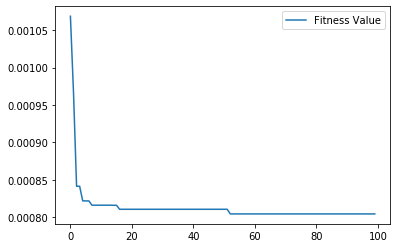

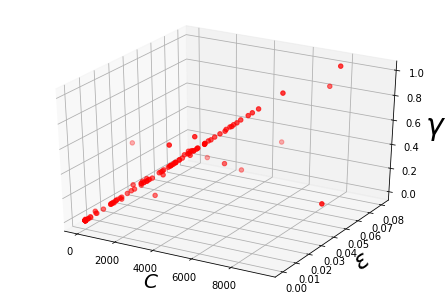

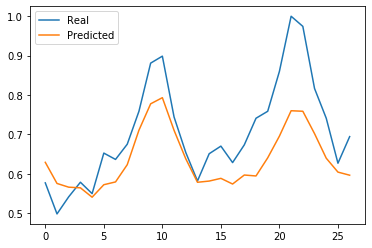

Least mean squared error: 0.009909


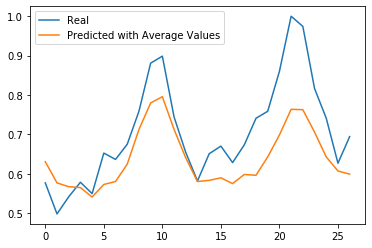

Least mean squared error for the average values: 0.009552


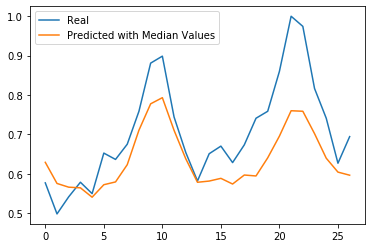

Least mean squared error for the median value: 0.009909


In [40]:
pso(120, 100, 3, 0.8)

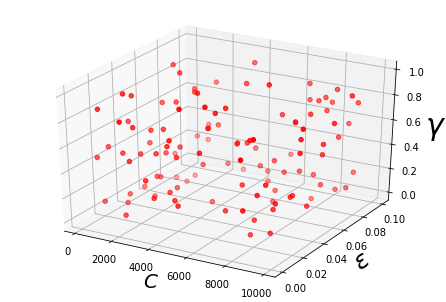

Best value iteration # 0 = 0.000931

Best value iteration # 1 = 0.000830

Best value iteration # 2 = 0.000830

Best value iteration # 3 = 0.000819

Best value iteration # 4 = 0.000819

Best value iteration # 5 = 0.000819

Best value iteration # 6 = 0.000819

Best value iteration # 7 = 0.000819

Best value iteration # 8 = 0.000815

Best value iteration # 9 = 0.000815

Best value iteration # 10 = 0.000815

Best value iteration # 11 = 0.000815

Best value iteration # 12 = 0.000815

Best value iteration # 13 = 0.000815

Best value iteration # 14 = 0.000814

Best value iteration # 15 = 0.000811

Best value iteration # 16 = 0.000811

Best value iteration # 17 = 0.000811

Best value iteration # 18 = 0.000811

Best value iteration # 19 = 0.000811

Best value iteration # 20 = 0.000811

Best value iteration # 21 = 0.000811

Best value iteration # 22 = 0.000811

Best value iteration # 23 = 0.000811

Best value iteration # 24 = 0.000811

Best value iteration # 25 = 0.000810

Best value iteration #

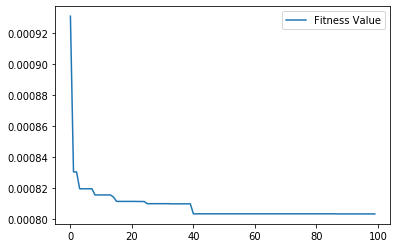

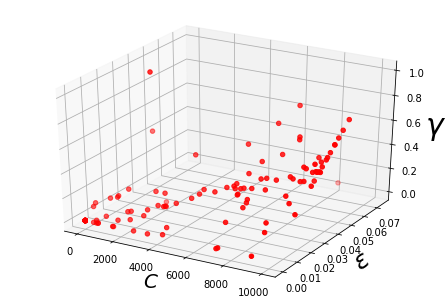

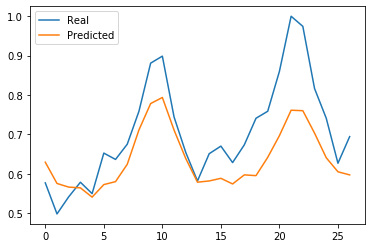

Least mean squared error: 0.009777


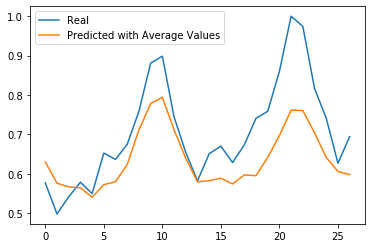

Least mean squared error for the average values: 0.009753


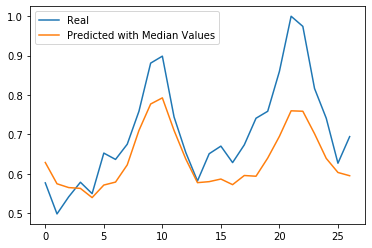

Least mean squared error for the median value: 0.009995


In [41]:
pso(120, 100, 3, 0.6)

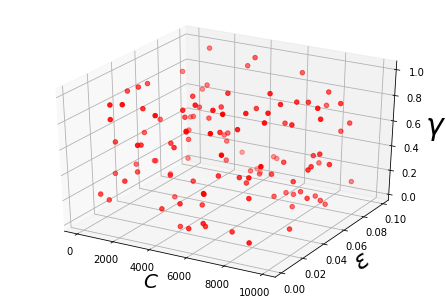

Best value iteration # 0 = 0.000871

Best value iteration # 1 = 0.000827

Best value iteration # 2 = 0.000827

Best value iteration # 3 = 0.000814

Best value iteration # 4 = 0.000814

Best value iteration # 5 = 0.000814

Best value iteration # 6 = 0.000814

Best value iteration # 7 = 0.000814

Best value iteration # 8 = 0.000814

Best value iteration # 9 = 0.000814

Best value iteration # 10 = 0.000814

Best value iteration # 11 = 0.000814

Best value iteration # 12 = 0.000814

Best value iteration # 13 = 0.000814

Best value iteration # 14 = 0.000814

Best value iteration # 15 = 0.000809

Best value iteration # 16 = 0.000809

Best value iteration # 17 = 0.000809

Best value iteration # 18 = 0.000809

Best value iteration # 19 = 0.000809

Best value iteration # 20 = 0.000809

Best value iteration # 21 = 0.000809

Best value iteration # 22 = 0.000809

Best value iteration # 23 = 0.000809

Best value iteration # 24 = 0.000809

Best value iteration # 25 = 0.000809

Best value iteration #

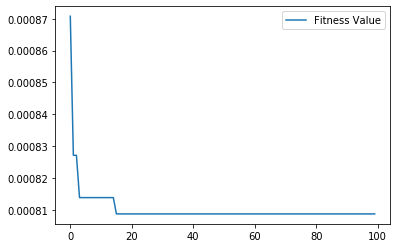

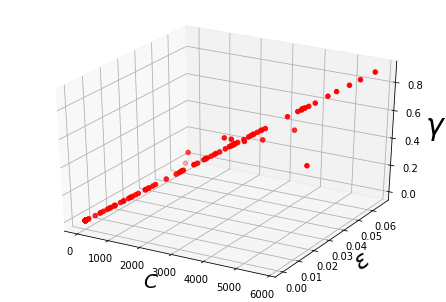

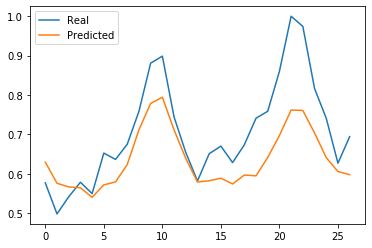

Least mean squared error: 0.009753


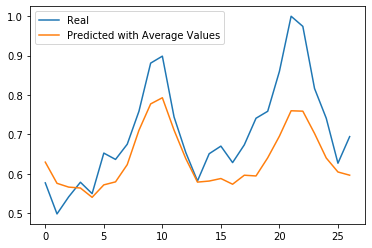

Least mean squared error for the average values: 0.009915


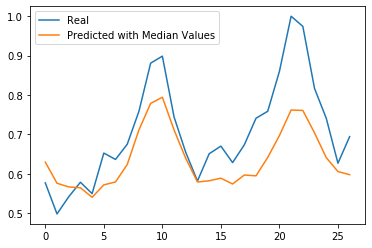

Least mean squared error for the median value: 0.009753


In [42]:
pso(120, 100, 3, 0.2)